# sources

https://github.com/openai/CLIP/blob/fcab8b6eb92af684e7ff0a904464be7b99b49b88/notebooks/Prompt_Engineering_for_ImageNet.ipynb
https://github.com/openai/CLIP#zero-shot-prediction

# Install the clip package and its dependencies


In [81]:
# remove # to download packages

#! pip install ftfy regex tqdm
#! pip install git+https://github.com/openai/CLIP.git

In [82]:
# Import libraries

import os
import numpy as np
import torch
import clip
import glob
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pkg_resources import packaging
from torch.utils.data import Subset

In [14]:
# available CLIP models
# In this experiment, ViT-L/14@336px is used, as this is also the default model in the original CLIP paper
print(clip.available_models())

# Loading in model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14@336px', device)

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


100%|████████████████████████████████████████| 891M/891M [00:08<00:00, 116MiB/s]


In [15]:
# Parameters model

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


# Loading in Handwritten Words dataset

Download handwritten dataset from Kaggle,
Or, run this code in Kaggle and load in the handwritten datasset.
https://kaggle.com/datasets/nabeel965/handwritten-words-dataset/

In [6]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
# Empty list to collect images
original_images = []

# Empty list to collect labels
labels = []

In [46]:
# Load in data, first upload the Handwritten Words dataset to your Google Drive!

for filename in [filename for filename in glob.glob("/content/drive/MyDrive/handwritten-words-dataset/data/small/**/**/*.jpg")]:
    name = os.path.splitext(filename)[0]
    filename_split = filename.split('/')
    name = filename_split[-2]

    image = Image.open(os.path.join(filename))

    original_images.append(image)
    labels.append(name)

In [47]:
# Check whether images are loaded in
# Dataset contains 2513 images
len(original_images)

2513

In [83]:
# When running code in Kaggle environment
# Load in images directly from Kaggle

#for filename in [filename for filename in glob.glob("../input/handwritten-words-dataset/data/small/**/**/*.jpg")]:
#    name = os.path.splitext(filename)[0]
#    filename_split = filename.split('/')
#    name = filename_split[-2]

#    image = Image.open(os.path.join(filename))

#    original_images.append(image)
#    labels.append(name)

In [49]:
# Create dataframe with the image transcriptions
df = pd.DataFrame(labels)

# Rename column to "Labels"
df.columns = ['Labels']

# Add images to dataframe
df['images'] = original_images

In [51]:
# labels are sorted and factorized, sorting is based on alphabetical order,
# This means that the images in the model have to be loaded in alphabetical order as well (!)

df['code'] = pd.factorize(df['Labels'], sort = True)[0]

In [53]:
#train = df.groupby('code').sample(frac=.8)
#test = df.loc[df.index.difference(train.index)]

In [54]:
#df.Labels.unique().sort()

In [55]:
# Words in dataset, in alphabetical order, matching the order of the factorized version of the labels

sorted(list(df.Labels.unique()))

['boxing', 'five', 'jump', 'quickly', 'the', 'wizards']

# Creating embeddings for images and text

In [ ]:
# Defining classes and templates
# Templates are combined and with the prompt you are looking for when encoded
# It is adviced to experiment with differemt templates / prompts, as this can influence how similar the text embedding is to the image embedding results

HW_classes = sorted(list(df.Labels.unique()))
HW_templates = ['a photo of the written word: "{}"',
               'a picture of the handwritten word: "{}"',
               'a picture of the written word: "{}", written by hand']

class_map = {'HW': HW_classes}

template_map = {'HW': HW_templates}

In [ ]:
# Defining function to calculate accuracy

@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res

In [ ]:
# Function to extract text features from text prompt

@torch.no_grad()
def extract_text_features(dataset_name):
    class_names = class_map[dataset_name]
    templates = template_map[dataset_name]
    model.to(device)
    model.eval()

    zeroshot_weights = []
    for classname in class_names:
        texts = [template.format(classname) for template in templates]
        texts = clip.tokenize(texts).to(device)
        class_embeddings = model.encode_text(texts)
        # embedding size = 768,  (= dimensionality of the encoder layers)
        # each template + class gets vector of length 768
        # size of tensor is (x, 768), x refers to the number of templates included
        # x = rows, 768 = columns
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        # normalized over rows (Frobenius Norm)
        # dimension remains (x, 768)
        class_embedding = class_embeddings.mean(dim=0)
        # Column wise mean is calculated
        # Vector of length 768 remains
        class_embedding /= class_embedding.norm()
        # vector is normalized (Frobenius normalization)
        zeroshot_weights.append(class_embedding)
        # every input (class + every possible template => mean) is represented as embedding of length 768
        # In this case, list of 10 embeddings with length 768
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    # list of embeddings is concatenated in matrix
    # embeddings are joined on column level

    torch.set_printoptions(profile="full")
    #print(zeroshot_weights)
    return zeroshot_weights


In [85]:
# Empty list to collect image features
image_features = []

# Empty list to collect image transcriptions
image_labels = []

In [86]:
# Loading in the data: images + transcription
# Images and transcriptions have to be loaded in in the same order!
for image, class_id in zip(df["images"], df["code"]):
    # Preprocess: pixel intensity is normalized using dataset mean and standard deviation.
    # Input images are resized and center-cropped to conform with the expected image resolution.
    image_input = preprocess(image).unsqueeze(0).to(device)
    #print(image_input.size())
    # unsqueeze(x), returns a new tensor with a dimension of size one inserted at the specified position.
    # x refers to the index at which to insert the singleton dimension

    with torch.no_grad():
        image_feature = model.encode_image(image_input)
        # matrix with dimenension (1, 768)

    image_feature /= image_feature.norm()
    # image features are normalized, if dim is None, the norm is calculated across all dimensions of input

    image_features.append(image_feature)
    # list of embedding (length 768) for each image
    image_labels.append(class_id)
    # Class id (the factorized ground truth) is added in a list of tensors


image_features = torch.stack(image_features, dim=-1).to(device)
# separate embeddings are concatenated on the second of 2 dimensions, (so on rows)
# The final matrix has the shape [768, 10]

# Squeeze to get a tensor returned where all the dimensions of input of size 1 are removed
image_features = image_features.squeeze()

  # extract text feature
text_features = extract_text_features('HW')

top-1 accuracy for = dataset: 96.419


In [87]:
# compute top-1 accuracy
logits = (100. * image_features.T @ text_features).softmax(dim=-1)
# image features are multiplied by text features, softmax converts real numbers into probability distribution
# Output tensor lies in range 0-1 and sums to 1
image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)

top1_acc = accuracy(logits, image_labels, (1,))

print(f'top-1 accuracy for = dataset: {top1_acc[0]:.3f}')

top-1 accuracy for = dataset: 96.419


<ipython-input-87-5577872695bd>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)


# Visualizing word that matches prompt the best

In [88]:

target_number = input("which word are you looking for? ")

which word are you looking for? a word that ends in -ive


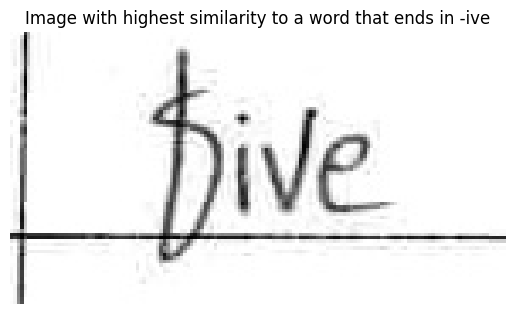

In [89]:
# Generate the text prompt for the target number
target_text = HW_templates[0].format(target_number)
target_text = clip.tokenize([target_text]).to(device)

# Encode the text prompt to get its feature
target_text_feature = model.encode_text(target_text)
target_text_feature /= target_text_feature.norm()

# Transpose the image features for compatibility
transposed_image_features = image_features.T

# Calculate similarity scores for each image
similarity_scores = transposed_image_features @ target_text_feature.T

# Find the index of the image with the highest similarity score
best_image_index = torch.argmax(similarity_scores)


# Convert the index to an integer
best_image_index = int(best_image_index)

# Retrieve the corresponding image from the DataFrame
best_image = df.iloc[best_image_index]['images']

# Convert the PIL Image to a NumPy array
best_image_np = np.array(best_image)

# Display the best image
plt.imshow(best_image_np, cmap='gray')  # Assuming it's a grayscale image
plt.title(f"Image with highest similarity to {target_number}")
plt.axis('off')  # Turn off axis labels
plt.show()
